In [ ]:
import pickle
import warnings
import numpy as np
import pandas as pd
import proplot as pplt
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [54]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/'

with open(f'{FILEDIR}/results/baseline_results.pkl','rb') as file:
    baseresults = pickle.load(file)
with open(f'{FILEDIR}/results/linear_results.pkl','rb') as file:
    linresults = pickle.load(file)
with open(f'{FILEDIR}/results/nonlinear_results.pkl','rb') as file:
    nonlinresults = pickle.load(file)

ytrue = pd.read_parquet(f'{FILEDIR}/processed/ytest.parquet')['pr']

In [11]:
def clean_data(*arrays):
    arrays  = [np.array(array) for array in arrays]
    lengths = [len(array) for array in arrays]
    if len(set(lengths))>1:
        raise ValueError(f'All arrays must have same length. Got lengths: {lengths}')
    validmask = np.ones(len(arrays[0]),dtype=bool)
    for array in arrays:
        validmask &= (np.isfinite(array)&(array>=1e-20))
    cleanedarrays = [array[validmask] for array in arrays]
    if len(cleanedarrays) == 1:
        return cleanedarrays[0]
    else:
        return tuple(cleanedarrays)

## Baseline Relationships

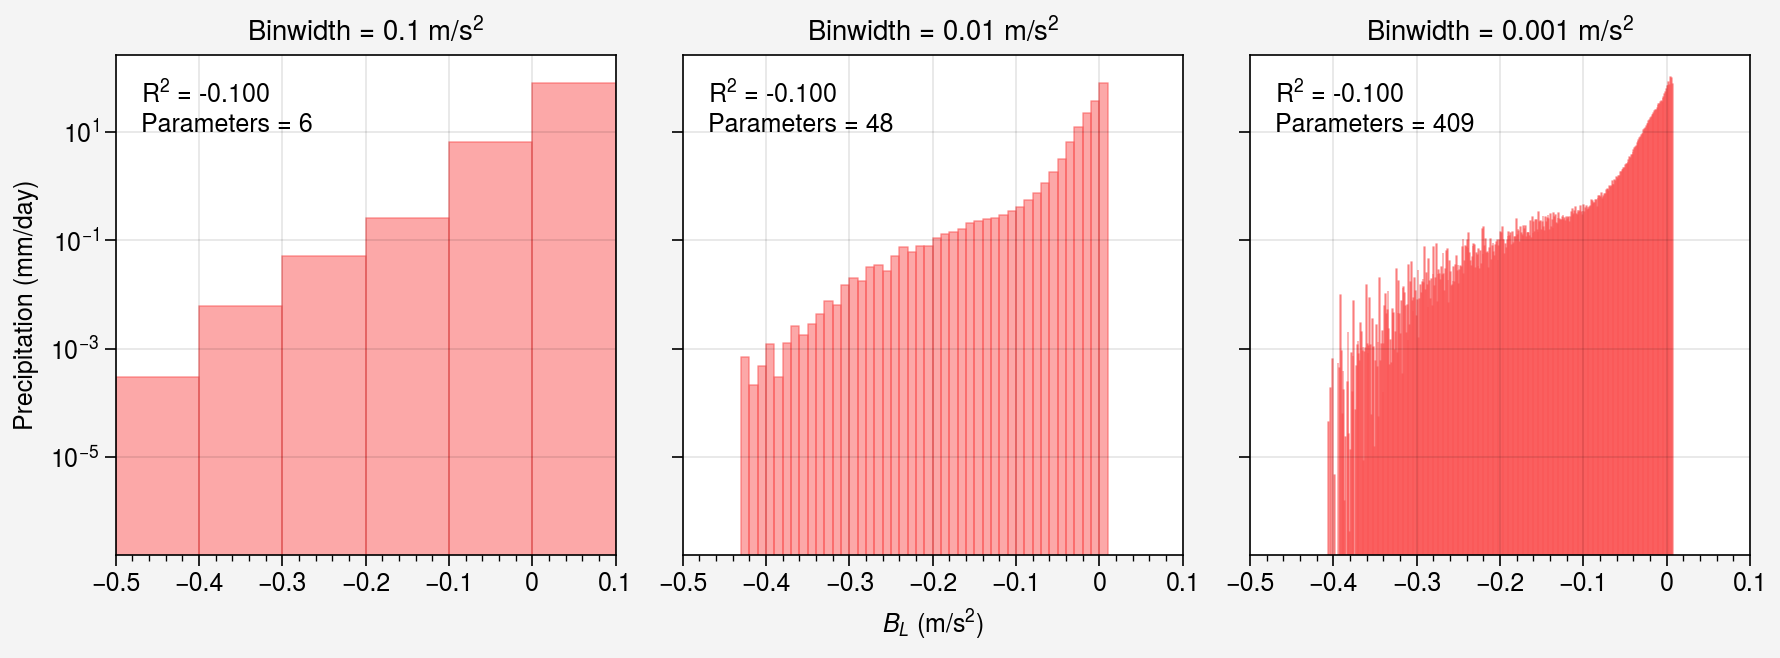

In [164]:
fig,axs = pplt.subplots(nrows=1,ncols=3,share=True)
axs.format(xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.5,0.1),xticks=0.1,ylabel='Precipitation (mm/day)',yscale='log',yformatter='log')
for i,(modelname,results) in enumerate(baseresults.items()):
    title    = results['description']
    bins     = results['bincenters']
    means    = results['binmeans']
    binwidth = results['binwidth']
    ypred    = results['ypred']
    nparams  = results['nparams']
    axs[i].format(title=f'{title} m/s$^2$')
    for bincenter,meanvalue in zip(bins,means):
        if not np.isnan(meanvalue):
            leftedge  = bincenter-binwidth/2
            rightedge = bincenter+binwidth/2
            axs[i].fill_between([leftedge,rightedge],[0,0],[meanvalue,meanvalue],color='red6',edgecolor='red6',alpha=0.5)
    axs[i].text(0.05,0.95,f'R$^2$ = {r2:.3f}\nParameters = {nparams}',transform=axs[i].transAxes,va='top')
pplt.show()

## Model Training and Validation Losses

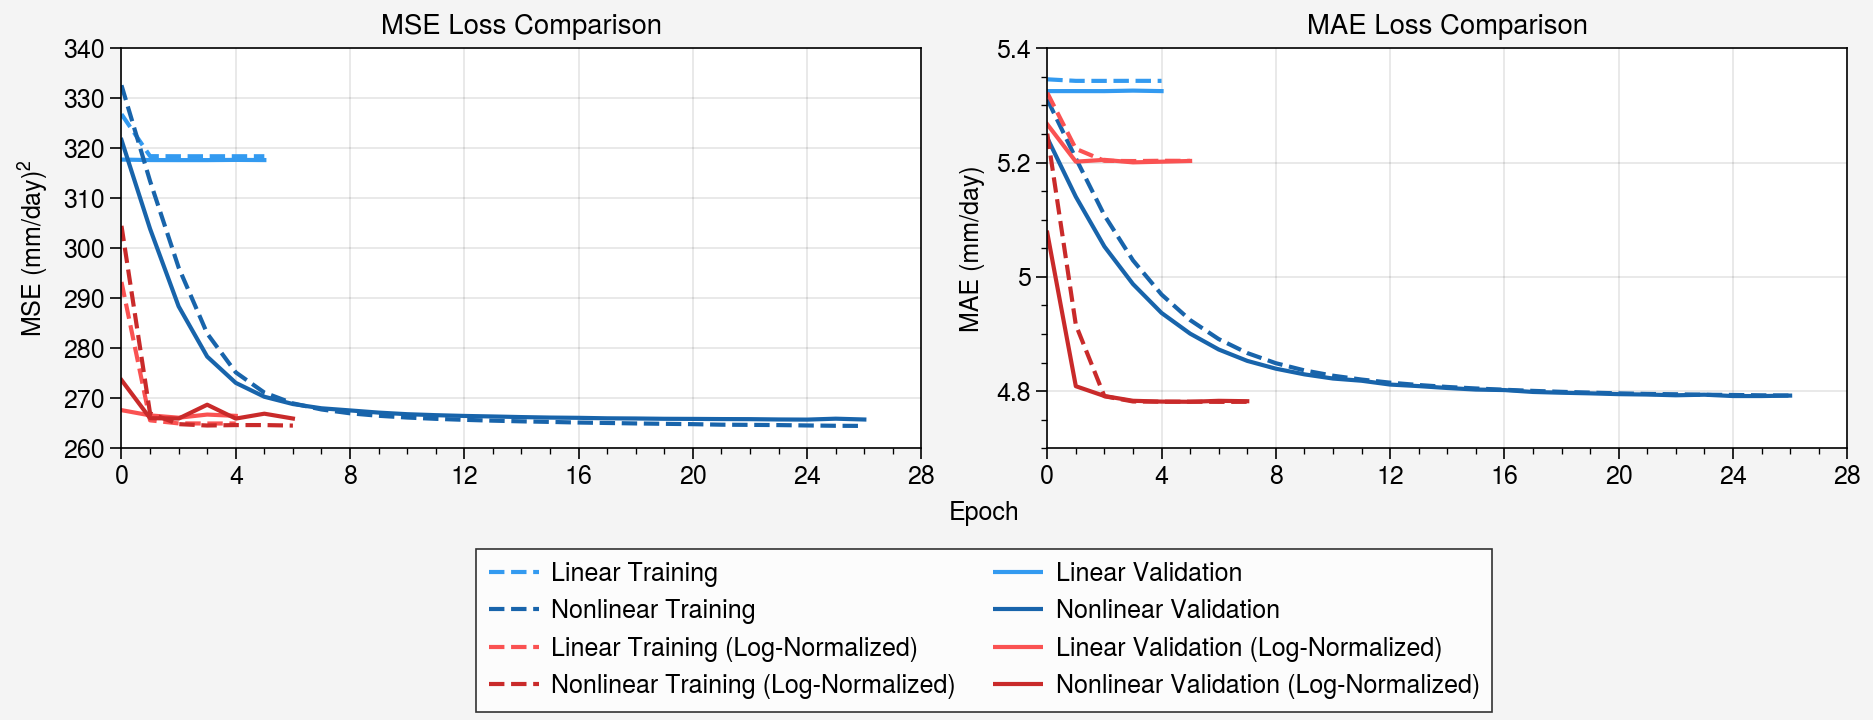

In [135]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,sharex=True,sharey=False)
axs.format(xlabel='Epoch',xlim=(0,28),xticks=4)
axs[0].format(title='MSE Loss Comparison',ylabel='MSE (mm/day)$^2$',ylim=(260,340),yticks=10,yminorticks='none')
axs[1].format(title='MAE Loss Comparison',ylabel='MAE (mm/day)',ylim=(4.7,5.4))
colors = ['blue5','blue9','red6','red9']
for i,(ax,loss) in enumerate(zip(axs,['mse','mae'])):
    ax.plot(linresults[f'linear_{loss}']['trainlosses'],color=colors[0],linestyle='--',label='Linear Training' if i==0 else None)
    ax.plot(linresults[f'linear_{loss}']['validlosses'],color=colors[0],linestyle='-',label='Linear Validation' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}']['trainlosses'],color=colors[1],linestyle='--',label='Nonlinear Training' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}']['validlosses'],color=colors[1],linestyle='-',label='Nonlinear Validation' if i==0 else None)
    ax.plot(linresults[f'linear_{loss}_log']['trainlosses'],color=colors[2],linestyle='--',label='Linear Training (Log-Normalized)' if i==0 else None)
    ax.plot(linresults[f'linear_{loss}_log']['validlosses'],color=colors[2],linestyle='-',label='Linear Validation (Log-Normalized)' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}_log']['trainlosses'],color=colors[3],linestyle='--',label='Nonlinear Training (Log-Normalized)' if i==0 else None)
    ax.plot(nonlinresults[f'relu_{loss}_log']['validlosses'],color=colors[3],linestyle='-',label='Nonlinear Validation (Log-Normalized)' if i==0 else None)
fig.legend(loc='b',ncols=2)
pplt.show()

## Cleaning All Precipitation Predictions

In [155]:
allmodels = []

for modelname,results in baseresults.items():
    ypred = results['ypred']
    ytrueclean,ypredclean = clean_data(ytrue,ypred)
    allmodels.append({
        'name':modelname,
        'description':results['description'],
        'ytrue':ytrueclean,
        'ypred':ypredclean,
        'nparams':results.get('nparams',None),
        'type':'baseline'})

for modelname,results in linresults.items():
    if results.get('logtransform',False):
        ypred = np.exp(results['ypred'])-1
    else:
        ypred = results['ypred']
    ypred = np.squeeze(ypred)
    ytrueclean,ypredclean = clean_data(ytrue,ypred)
    allmodels.append({
        'name':modelname,
        'description':results['description'],
        'ytrue':ytrueclean,
        'ypred':ypredclean,
        'nparams':results.get('nparams',None),
        'type':'linear'})

for modelname,results in nonlinresults.items():
    if results.get('logtransform',False):
        ypred = np.exp(results['ypred'])-1
    else:
        ypred = results['ypred']
    ypred = np.squeeze(ypred) 
    ytrueclean,ypredclean = clean_data(ytrue,ypred)
    allmodels.append({
        'name':modelname,
        'description':results['description'],
        'ytrue':ytrueclean,
        'ypred':ypredclean,
        'nparams':results.get('nparams',None),
        'type':'nonlinear'})

## Calculate Global Min/Max

In [156]:
allytrue = []
allypred = []
for model in allmodels:
    allytrue.extend(model['ytrue'])
    allypred.extend(model['ypred'])

globalmin = min(min(allytrue),min(allypred))
globalmax = max(max(allytrue),max(allypred))

## Actual vs. Predicted Precipitation

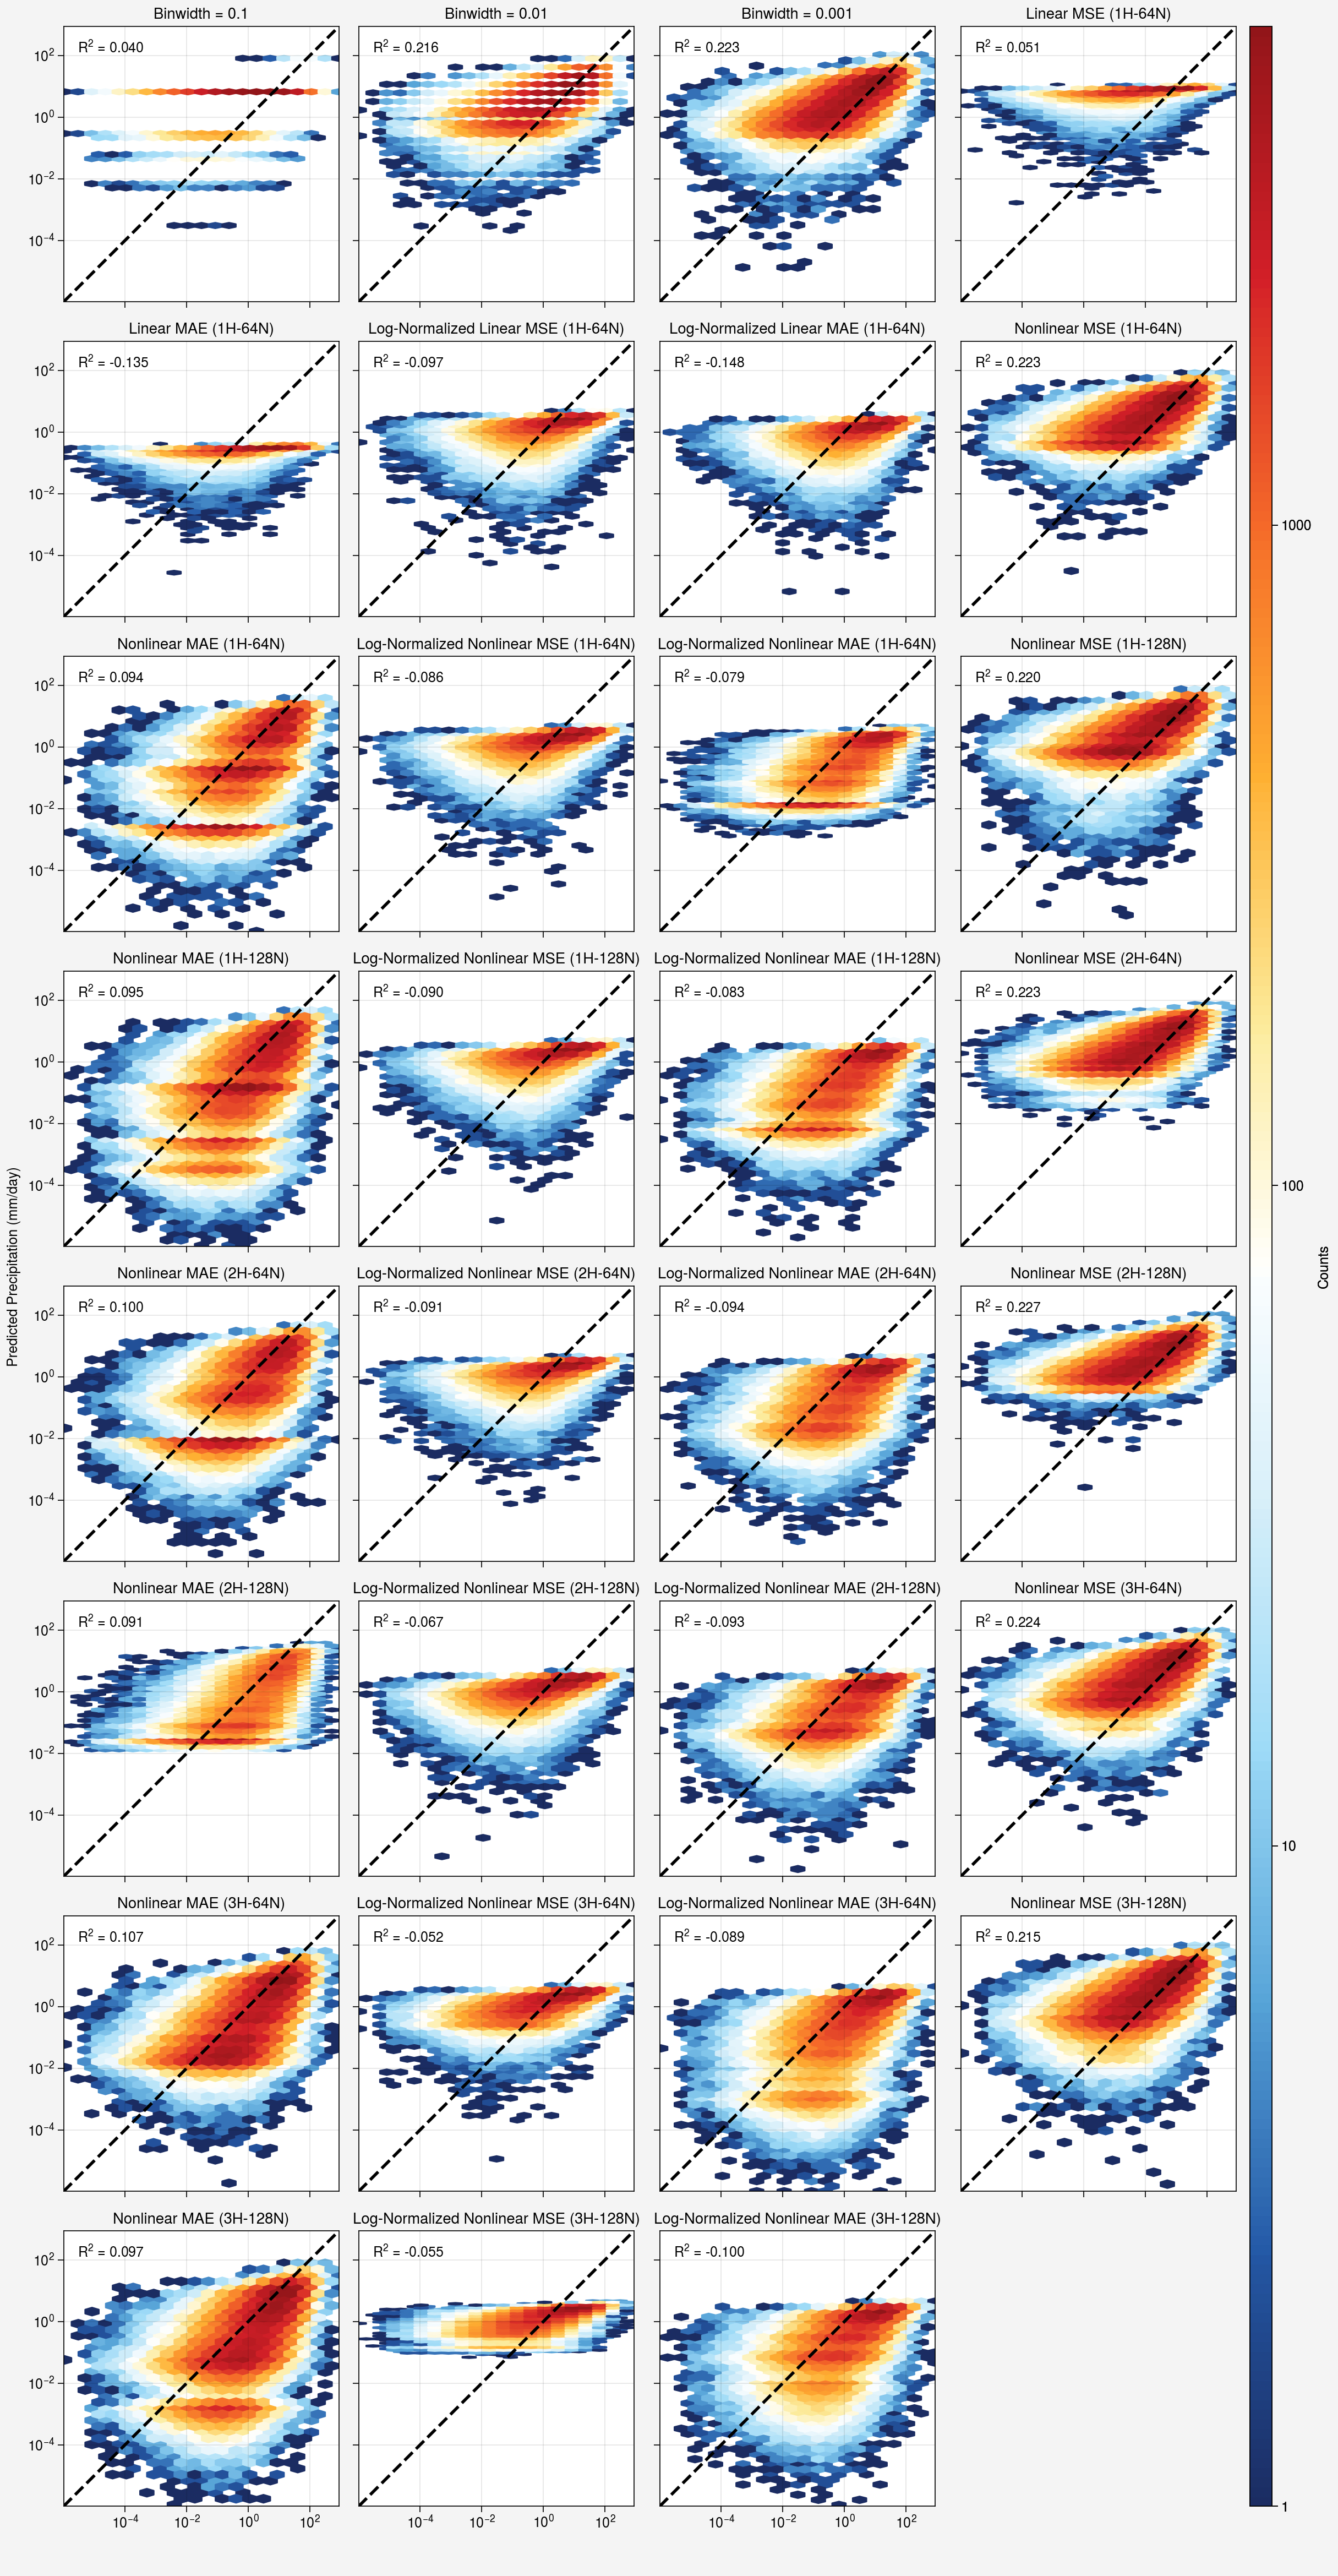

In [157]:
ncols   = 4
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,share=True)
for i,model in enumerate(allmodels):
    row  = i//ncols
    col  = i%ncols
    r2   = r2_score(model['ytrue'],model['ypred'])
    mesh = axs[row,col].hexbin(model['ytrue'],model['ypred'],gridsize=(20,20),cmap='ColdHot',mincnt=1,xscale='log',yscale='log',norm='log')
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=2)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2:.3f}',transform=axs[row,col].transAxes,va='top')
    axs[row,col].format(title=f'{model["description"]}')
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
axs.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xlim=[globalmin,globalmax],xformatter='log',xticks=ticks,xminorticks='none',
           ylabel='Predicted Precipitation (mm/day)',yscale='log',ylim=[globalmin,globalmax],yformatter='log',yticks=ticks,yminorticks='none')
fig.colorbar(mesh,loc='r',label='Counts',ticks=[1,10,100,1000,10000])
pplt.show()

## Actual vs. Predicted Precipitation Distributons

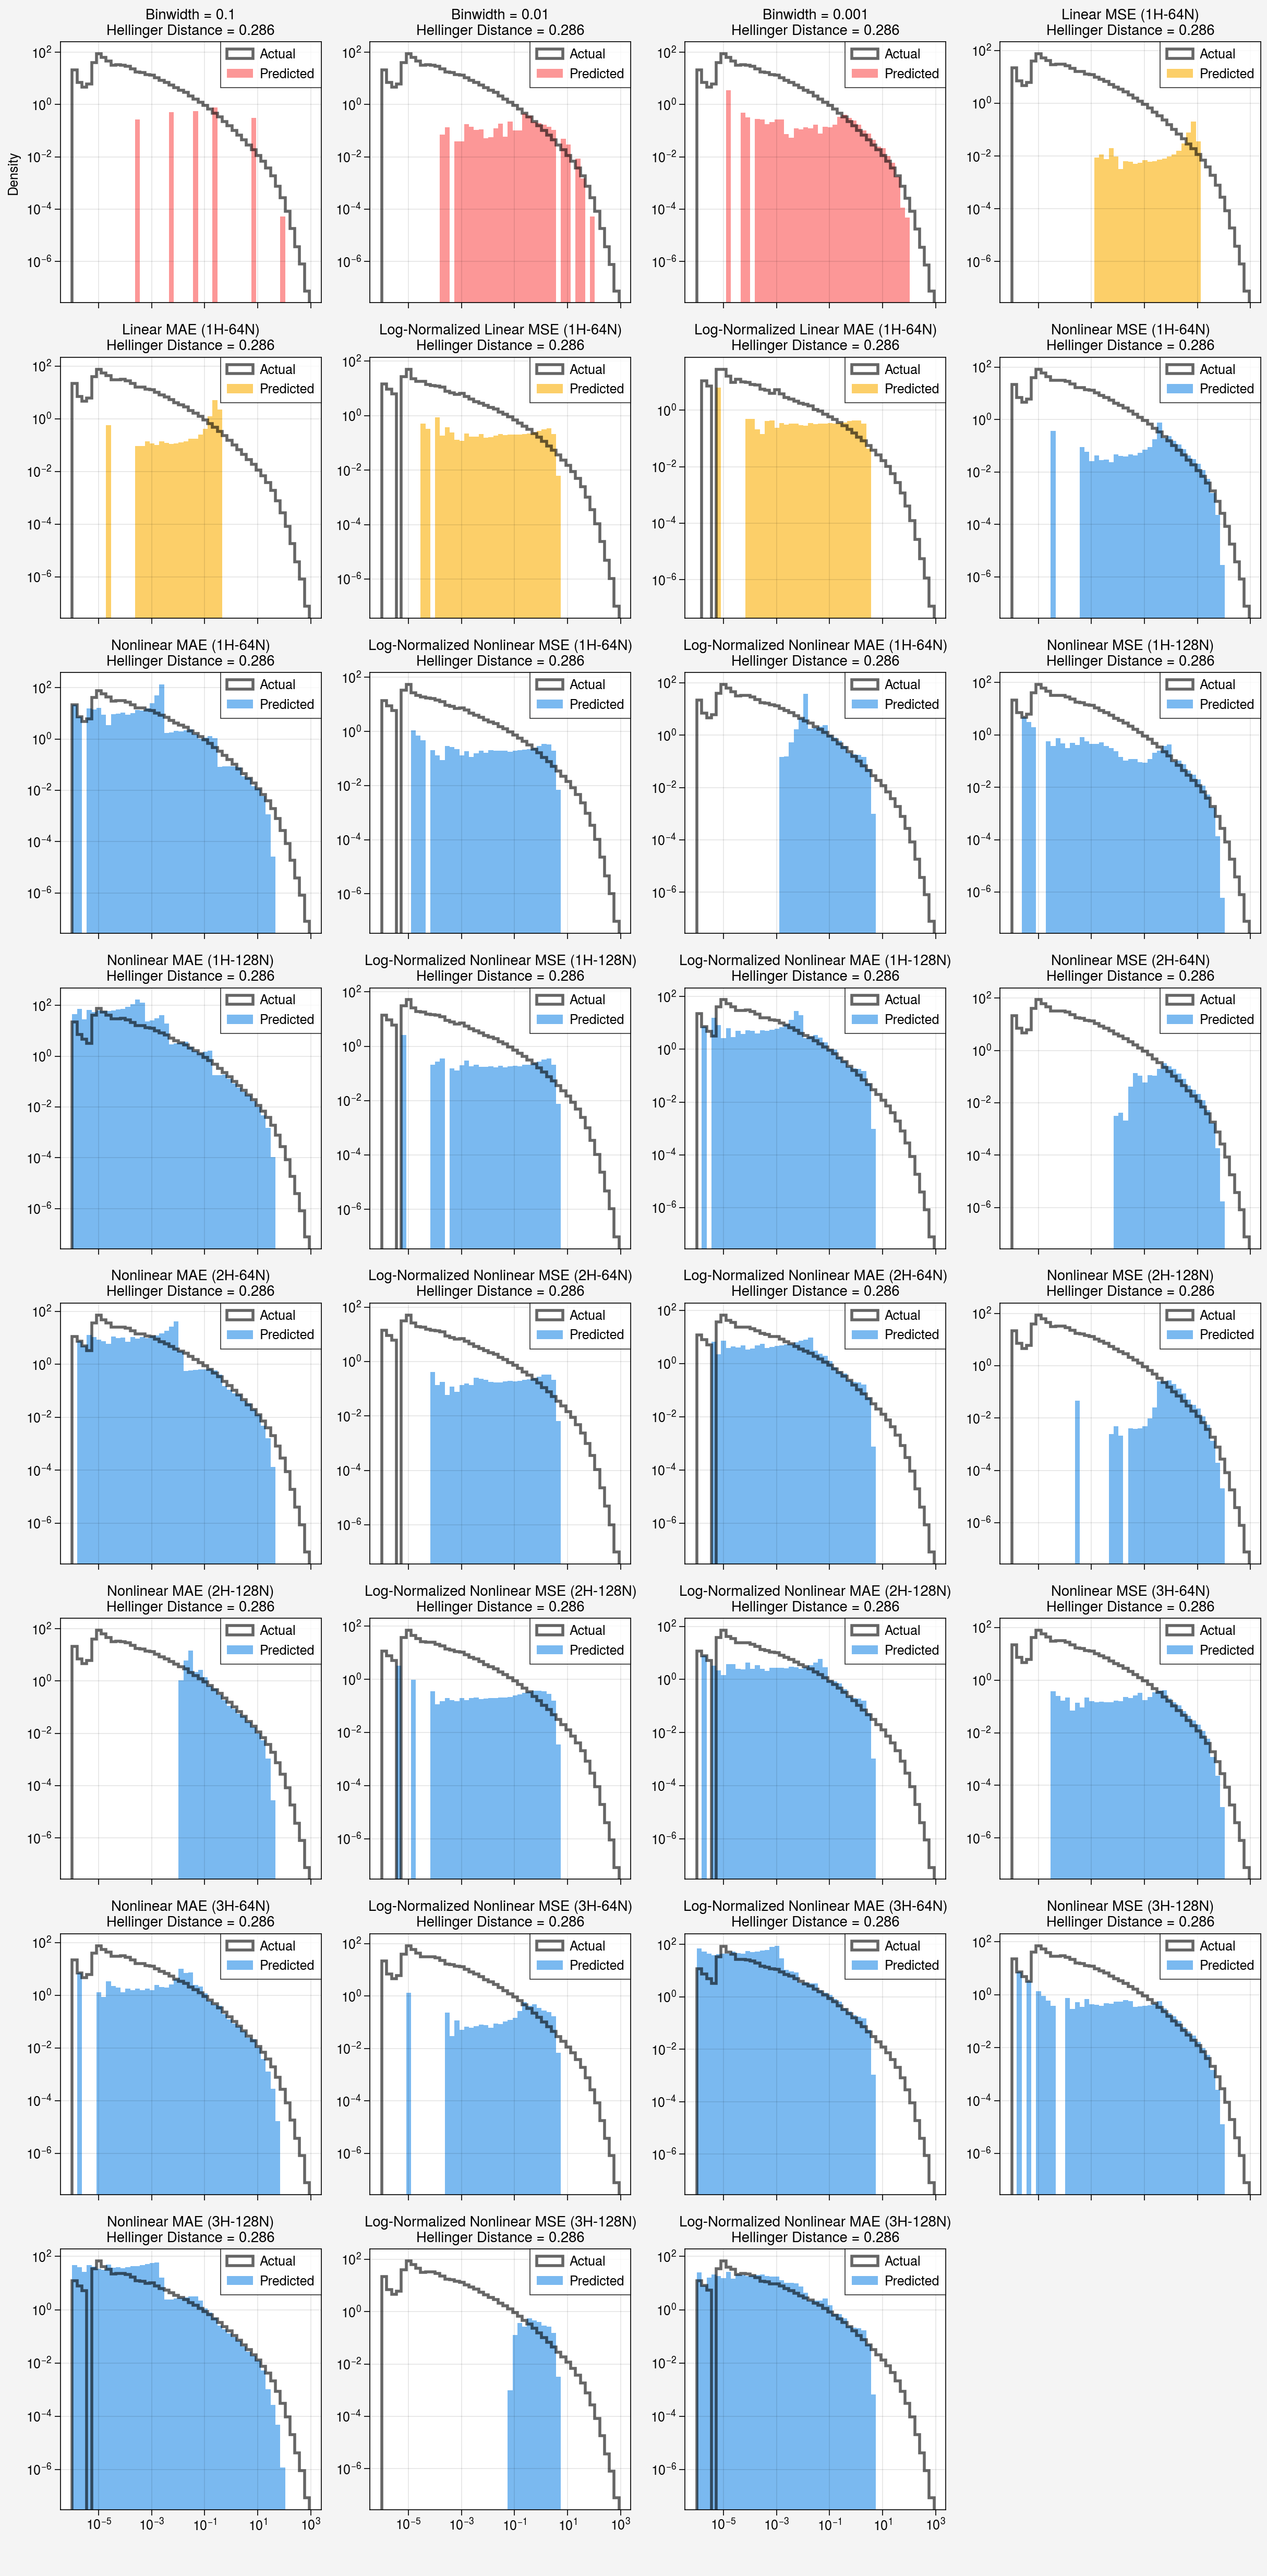

In [166]:
def hellinger_distance(p,q):
    minlength = min(len(p),len(q))
    p = p[:minlength]
    q = q[:minlength]
    p = p/np.sum(p)
    q = q/np.sum(q)
    return np.sqrt(0.5*np.sum((np.sqrt(p)-np.sqrt(q))**2))

ncols = 4
nrows = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,sharex=True,sharey=False)
axs.format(xlabel='Precipitation (mm/day)',xscale='log',xformatter='log',yscale='log',yformatter='log')
axs[0,0].format(ylabel='Density')
binedges = np.logspace(np.log10(globalmin),np.log10(globalmax),50)
colors = {'baseline':'red6','linear':'yellow6','nonlinear':'blue6'}
for i,model in enumerate(allmodels):
    row = i//ncols
    col = i%ncols
    ytrue     = model['ytrue']
    ypred     = model['ypred']
    title     = model['description']
    modeltype = model['type']
    r2 = r2_score(ytrue,ypred)
    histtrue,_ = np.histogram(ytrueclean,bins=binedges,density=True)
    histpred,_ = np.histogram(ypredclean,bins=binedges,density=True)
    hellinger  = hellinger_distance(histtrue,histpred)
    axs[row,col].hist(ytrue,bins=binedges,density=True,alpha=0.6,histtype='step',color='k',linewidth=2,label='Actual')
    axs[row,col].hist(ypred,bins=binedges,density=True,alpha=0.6,color=colors[modeltype],label='Predicted')
    axs[row,col].format(title=f'{title}\nHellinger Distance = {hellinger:.3f}')
    axs[row,col].legend(loc='ur',ncols=1)
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
pplt.show()

## Calculate Metrics

In [169]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def hellinger_distance(p,q):
    minlength = min(len(p),len(q))
    p = p[:minlength]
    q = q[:minlength]
    p = p/np.sum(p)
    q = q/np.sum(q)
    return np.sqrt(0.5*np.sum((np.sqrt(p)-np.sqrt(q))**2))

def calculate_metrics(allmodels):
    metricsdata = []
    for model in allmodels:
        ytrue = model['ytrue']
        ypred = model['ypred']
        r2   = r2_score(ytrue,ypred)
        mae  = mean_absolute_error(ytrue,ypred)
        mse  = mean_squared_error(ytrue,ypred)
        rmse = np.sqrt(mse)
        histtrue,_ = np.histogram(ytrue,bins=np.logspace(np.log10(globalmin),np.log10(globalmax),50),density=True)
        histpred,_ = np.histogram(ypred,bins=np.logspace(np.log10(globalmin),np.log10(globalmax),50),density=True)
        hellinger  = hellinger_distance(histtrue,histpred)
        bias = np.mean(ypred-ytrue)
        correlation = np.corrcoef(ytrue,ypred)[0,1]
        relativemae = mae/np.mean(ytrue)
        metricsdata.append({
            'model':model['name'],
            'description':model['description'],
            'type':model['type'],
            'r2':r2,
            'mae':mae,
            'mse':mse,
            'rmse':rmse,
            'hellinger':hellinger,
            'bias':bias,
            'correlation':correlation,
            'relative_mae':relativemae})
    return pd.DataFrame(metricsdata)

metricsdf = calculate_metrics(allmodels)

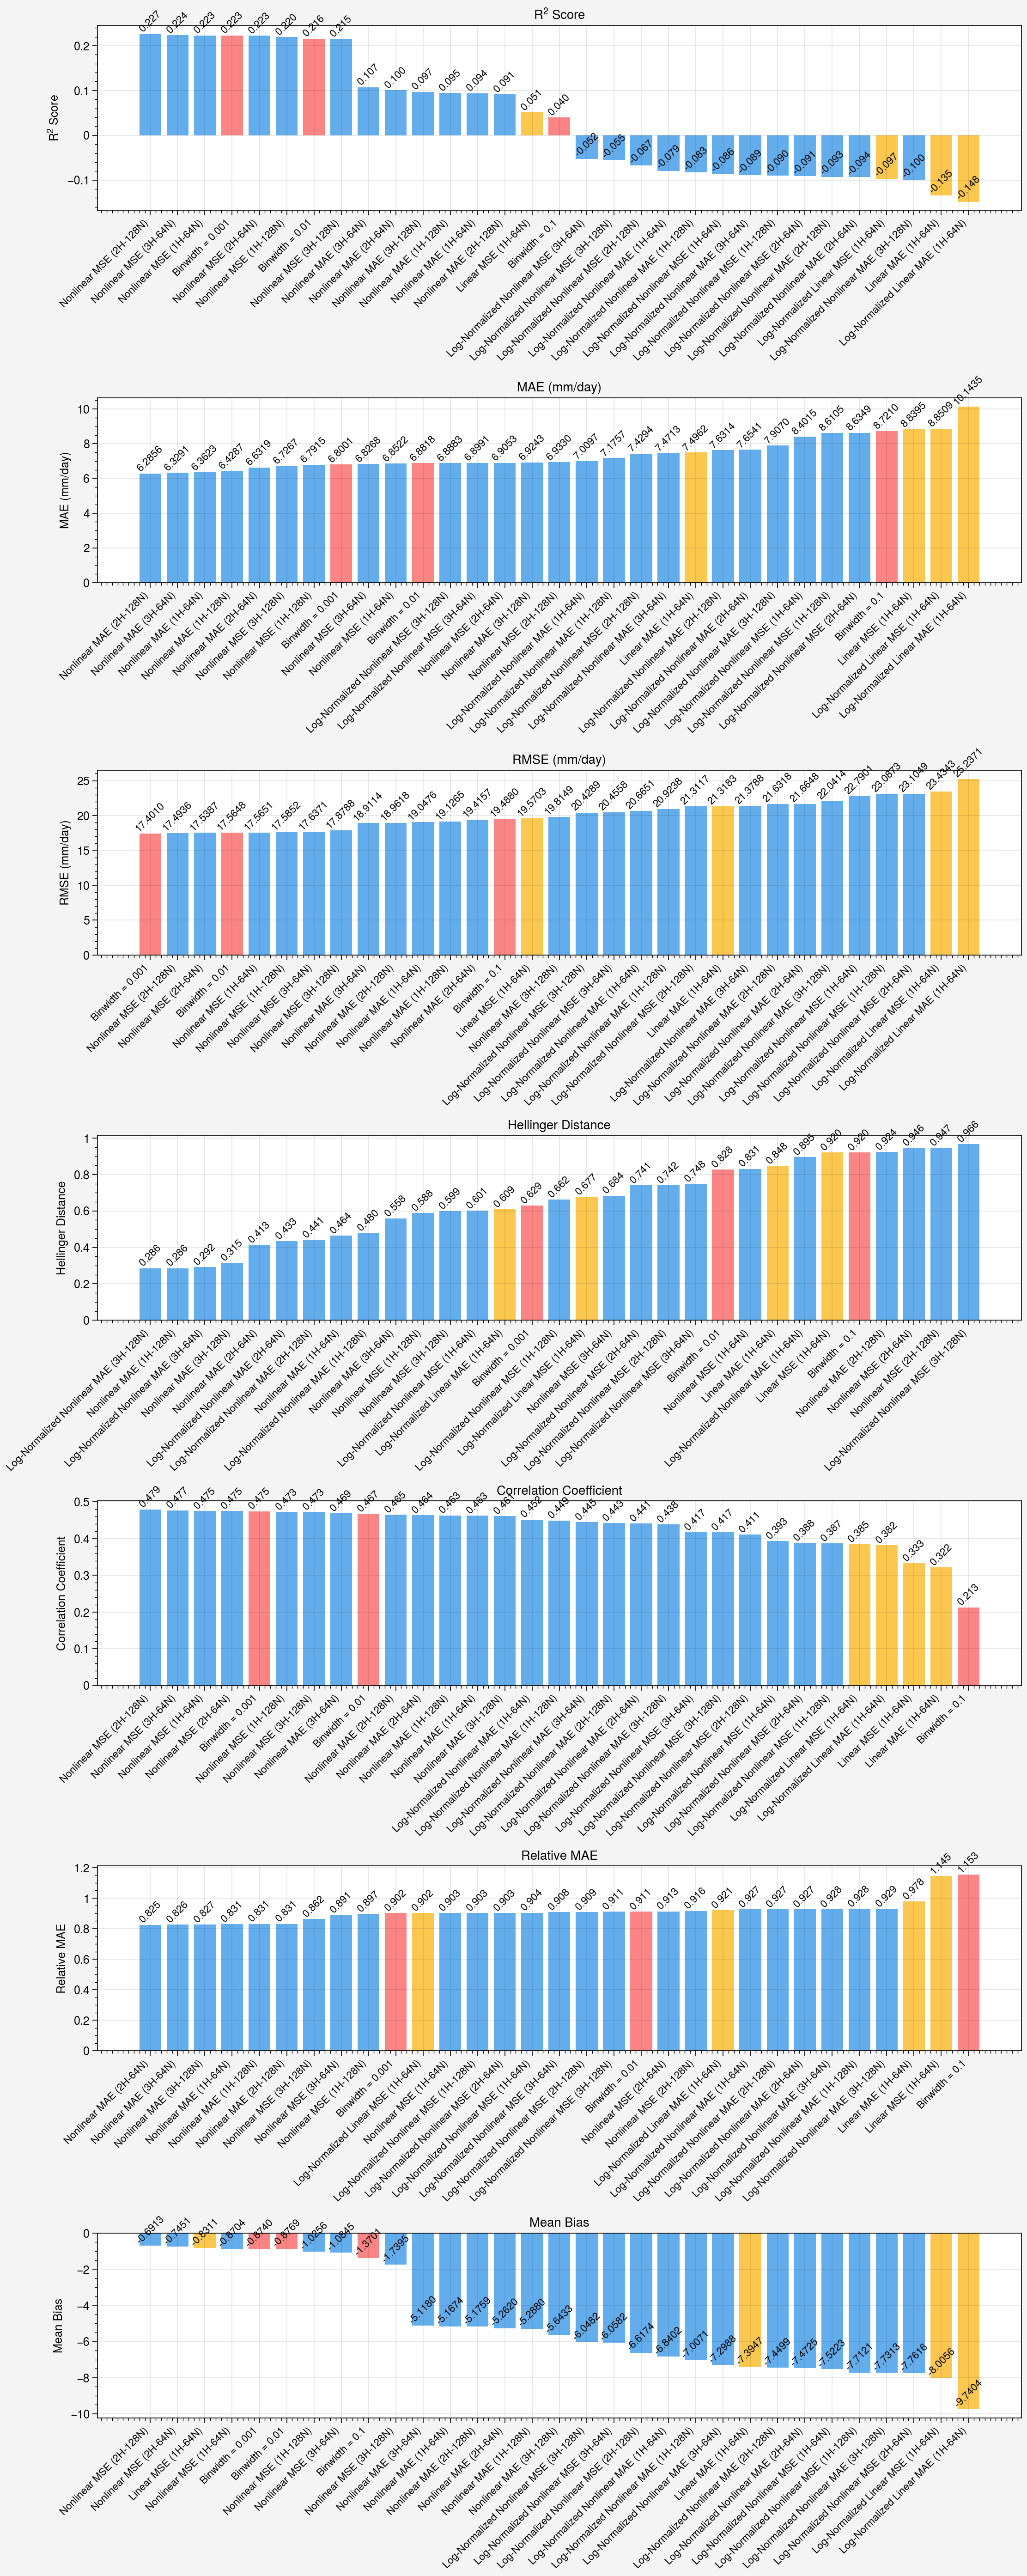

In [180]:
metricsconfig = {
    'r2':{'title':'R$^2$ Score','higher_better':True,'format':'.3f'},
    'mae':{'title':'MAE (mm/day)','higher_better':False,'format':'.4f'},
    'rmse':{'title':'RMSE (mm/day)','higher_better':False,'format':'.4f'},
    'hellinger':{'title':'Hellinger Distance','higher_better':False,'format':'.3f'},
    'correlation':{'title':'Correlation Coefficient','higher_better':True,'format':'.3f'},
    'relative_mae':{'title':'Relative MAE','higher_better': False,'format':'.3f'},
    'bias':{'title':'Mean Bias','higher_better':None,'format':'.4f'}}
ncols   = 1
nrows   = (len(metricsconfig)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=10,refheight=2,share=False)
typecolors = {'baseline':'red6','linear':'yellow6','nonlinear':'blue6'}
for i,(metric,config) in enumerate(metricsconfig.items()):
    row = i//ncols
    col = i%ncols
    if config['higher_better'] is True:
        sorteddf = metricsdf.sort_values(metric,ascending=False)
    elif config['higher_better'] is False:
        sorteddf = metricsdf.sort_values(metric,ascending=True)
    else:  
        sorteddf = metricsdf.sort_values(metric,key=abs,ascending=True)
    colors = [typecolors[modeltype] for modeltype in sorteddf['type']]
    bars   = axs[row,col].bar(range(len(sorteddf)),sorteddf[metric],color=colors,alpha=0.7)
    axs[row,col].format(title=config['title'],ylabel=config['title'])
    for j,(bar,value) in enumerate(zip(bars,sorteddf[metric])):
        height = bar.get_height()
        axs[row,col].text(bar.get_x()+bar.get_width()/2.,height,f'{value:{config["format"]}}',ha='center',va='bottom',fontsize=8,rotation=45)
    axs[row,col].set_xticks(range(len(sorteddf)))
    axs[row,col].set_xticklabels([desc for desc in sorteddf['description']],rotation=45,ha='right',fontsize=8)
    # axs[row,col].set_xticklabels([desc[:15]+'...' if len(desc)>15 else desc for desc in sorteddf['description']],rotation=45,ha='right',fontsize=8)
for i in range(len(metricsconfig),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
pplt.show()